# 23. Convolutional AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 23.1 Preparing SVHN Data

In [3]:
svhn_train = dsets.SVHN(root='data/',
                          split='train',
                          transform=transforms.ToTensor(),
                          download=True)

svhn_test = dsets.SVHN(root='data/',
                         split='test',
                         transform=transforms.ToTensor(),
                         download=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=svhn_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=svhn_test,
                                         batch_size=1,
                                         shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

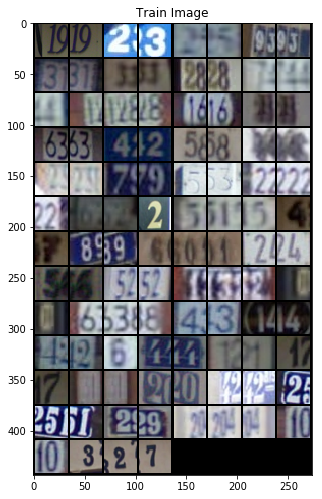

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 23.2 Define Model

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,5),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*4*4
        )
        
    def forward(self, x):
        z = self.encoder(x)
        
        return z

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,3,4,stride=2,padding=1),
            nn.ReLU()
        )
        
    def forward(self, z):
        out = self.decoder(z)
        out = out.view(-1,3,32,32)
        
        return out

In [9]:
E = Encoder().cuda()
D = Decoder().cuda()

## 22.3 Model Training

In [10]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [11]:
num_epochs = 25

In [12]:
for epoch in range(num_epochs):
    
    total_batch = len(svhn_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = Variable(batch_images).cuda()
        
        pre = D(E(X))
        cost = loss(pre, X)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.data[0]))
    
print("Learning Finished!")

Epoch [1/25], lter [100/732] Loss: 0.0210
Epoch [1/25], lter [200/732] Loss: 0.0114
Epoch [1/25], lter [300/732] Loss: 0.0111
Epoch [1/25], lter [400/732] Loss: 0.0119
Epoch [1/25], lter [500/732] Loss: 0.0081
Epoch [1/25], lter [600/732] Loss: 0.0092
Epoch [1/25], lter [700/732] Loss: 0.0084
Epoch [2/25], lter [100/732] Loss: 0.0076
Epoch [2/25], lter [200/732] Loss: 0.0074
Epoch [2/25], lter [300/732] Loss: 0.0071
Epoch [2/25], lter [400/732] Loss: 0.0093
Epoch [2/25], lter [500/732] Loss: 0.0066
Epoch [2/25], lter [600/732] Loss: 0.0077
Epoch [2/25], lter [700/732] Loss: 0.0067
Epoch [3/25], lter [100/732] Loss: 0.0064
Epoch [3/25], lter [200/732] Loss: 0.0064
Epoch [3/25], lter [300/732] Loss: 0.0061
Epoch [3/25], lter [400/732] Loss: 0.0085
Epoch [3/25], lter [500/732] Loss: 0.0060
Epoch [3/25], lter [600/732] Loss: 0.0072
Epoch [3/25], lter [700/732] Loss: 0.0062
Epoch [4/25], lter [100/732] Loss: 0.0061
Epoch [4/25], lter [200/732] Loss: 0.0060
Epoch [4/25], lter [300/732] Loss:

## 22.4 Test Model

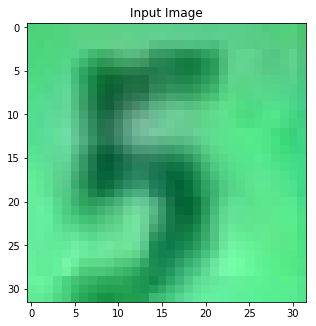

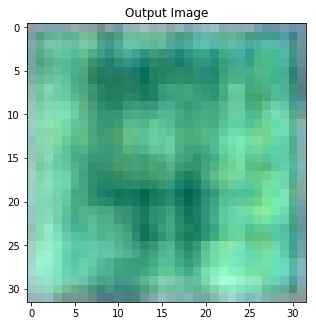

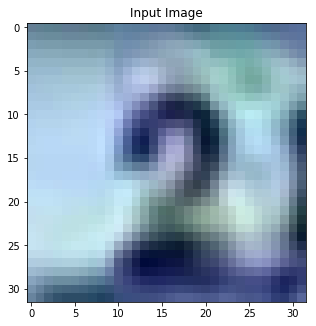

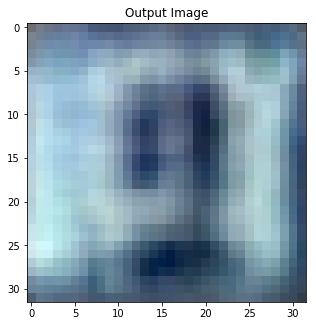

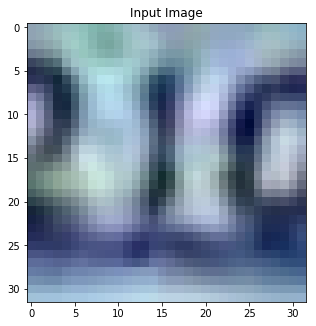

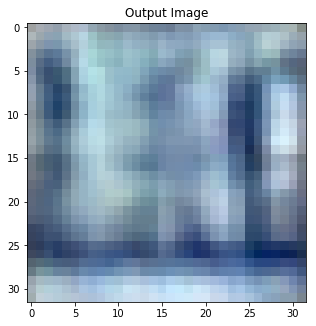

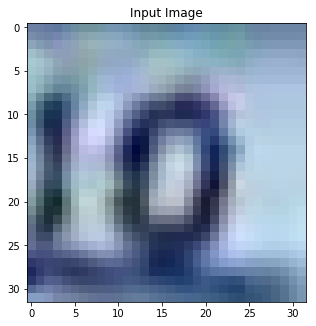

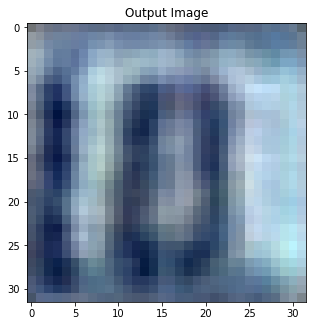

In [13]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    imshow(torchvision.utils.make_grid(images, normalize=True), "Input Image")
    images = Variable(images.view(-1, 3, 32, 32)).cuda()
    
    outputs = D(E(images))
    outputs = outputs.view(-1, 3, 32, 32)
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break

## 22.5 Make Random Image

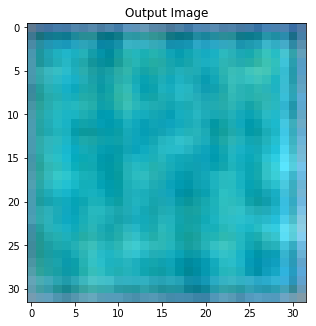

In [14]:
z = Variable(torch.rand(E(images).size())).cuda()

outputs = D(z)
outputs = outputs.view(-1, 3, 32, 32)

imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")